### 对应到完整版本Alg.4

In [47]:
import numpy as np
from TDD.TDD import TDD, Ini_TDD,Clear_TDD,set_index_order,get_unique_table_num,set_root_of_unit,get_count,cont,renormalize,Slicing2,Slicing,get_index_order
from TDD.TDD import get_the_map_header
from TDD.TDD_Q import cir_2_tn,get_real_qubit_num,add_trace_line,add_inputs,add_outputs,gen_cir
from TDD.TN import Index,Tensor,TensorNetwork
import time
import random
from qiskit import QuantumCircuit,qasm2
import cProfile
from IPython.display import display, HTML,Image
# from PIL import Image
from PIL import Image as PILImage
import networkx as nx
import copy
from qiskit.circuit.library.standard_gates import HGate,U1Gate,U3Gate
from qiskit.quantum_info.operators import Operator
from qiskit.circuit.library import UnitaryGate
from Pre import *

to_test = False

In [48]:
def state_pre2(tdd,n=0,qa = 0,cond={},anc_num=1):


    if tdd.node.key==-1:
        return Circuit(0,[]),1
        
    if n==0:
        n = tdd.node.key+1
    cir = Circuit(n+1,[])
    # qa = n
    
    the_map=tdd.map

    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            # cir.x(q)
            cir.data.append(Gate('x',{},q))
        if the_map.rotate>0:
            # cir.p(np.pi/4*(8-the_map.rotate),q)
            cir.data.append(Gate('p',{},q,np.pi/4*(8-the_map.rotate)))
        the_map=the_map.father
    
    u = tdd.node
    the_map = u.out_maps[1]
    
    while the_map.level>-1:
        q1 = u.key
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            # cir.ccx(qa,q1,q)
            cir.data.append(Gate('x',{qa:1,q1:1},q))
        if the_map.rotate>0:
            # cir.mcp(np.pi/4*(8-the_map.rotate),[qa, q1],q)
            cir.data.append(Gate('p',{qa:1,q1:1},q,np.pi/4*(8-the_map.rotate)))
        the_map=the_map.father
    
    if u.successor[0]!=u.successor[1]:
        #把1分支关闭
        cond_qubit = [u.key] + [k for k in cond]
        for k in cond:
            if cond[k]==0:
                # cir.x(k)
                cir.data.append(Gate('x',{},k))
        # print('a',cond_qubit,qa)
        # cir.mcx(cond_qubit,qa)
        cir.data.append(Gate('x',{k:1 for k in cond_qubit},qa))
        for k in cond:
            if cond[k]==0:
                # cir.x(k)
                cir.data.append(Gate('x',{},k))
    
    # cond[u.key]=0
        bran_tdd = get_branch_dd(u,0)
        cir_end_t0, hold_prob0 = state_pre2(bran_tdd,n,qa,cond|{u.key:0},anc_num)
        cir.data=cir.data+cir_end_t0.data
        
    # if u.successor[0]!=u.successor[1]:
        #把0分支关闭，1分支打开
        cond_qubit = [k for k in cond]
        if len(cond_qubit)==0:
            # cir.x(qa)
            cir.data.append(Gate('x',{},qa))
        else:
            for k in cond:
                if cond[k]==0:
                    # cir.x(k)
                    cir.data.append(Gate('x',{},k))
            # print('b',cond_qubit,qa)
            # cir.mcx(cond_qubit,qa)
            cir.data.append(Gate('x',{k:1 for k in cond_qubit},qa))
            for k in cond:
                if cond[k]==0:
                    # cir.x(k)
                    cir.data.append(Gate('x',{},k))
        
        bran_tdd = get_branch_dd(u,1)
        cir_end_t1, hold_prob1 = state_pre2(bran_tdd,n,qa,cond|{u.key:1},anc_num)
        cir.data=cir.data+cir_end_t1.data
        
        #把0分支再打开
        cond_qubit = [u.key] + [k for k in cond]
        # cir.x(u.key)
        cir.data.append(Gate('x',{},u.key))
        for k in cond:
            if cond[k]==0:
                # cir.x(k)
                cir.data.append(Gate('x',{},k))
        # print('c',cond_qubit,qa)
        # cir.mcx(cond_qubit,qa)
        cir.data.append(Gate('x',{k:1 for k in cond_qubit},qa))
        for k in cond:
            if cond[k]==0:
                # cir.x(k)
                cir.data.append(Gate('x',{},k))
        # cir.x(u.key)
        cir.data.append(Gate('x',{},u.key))
    else:
        bran_tdd = get_branch_dd(u,0)
        cir_end_t0, hold_prob0 = state_pre2(bran_tdd,n,qa,cond,anc_num)
        cir.data=cir.data+cir_end_t0.data
        hold_prob1 = hold_prob0        
        
    w0 = u.out_weight[0]*hold_prob0
    w1 = u.out_weight[1]*hold_prob1
    a=w1/w0
    if abs(a)>1e-10:
        M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
        # u3 = UnitaryGate(M)
        # cu3 = u3.control(1)
        # cir.append(cu3,[qa,u.key])
        # print(qa,u.key,M)
        g = Gate('u',{qa:1},u.key,M)
        cir.data.append(Gate('u',{qa:1},u.key,M))
    hold_prob = w0*np.sqrt(1+abs(a)**2)
    return cir, hold_prob



def state_pre(tdd,anc_num=0):
    global S, node_qubit

    if anc_num==0:
        print('Need at least one ancilla qubit')
        return 
    Q = [tdd.node]
    S=[]

    n = tdd.node.key+1
    # cir = QuantumCircuit(n+anc_num)
    cir = Circuit(n+anc_num,[])
    anc_avi = n
    node_qubit = {}
    get_ref(tdd.node,[])

    the_map=tdd.map
    while the_map.level>-1:
        idx = the_map.level
        q = int(tdd.key_2_index[idx][1:])
        if the_map.x==1:
            # cir.x(q)
            cir.data.append(Gate('x',{},q))
        if the_map.rotate>0:
            # cir.p(np.pi/4*(8-the_map.rotate),q)
            cir.data.append(Gate('p',{},q,np.pi/4*(8-the_map.rotate)))
        # print(q)
        the_map=the_map.father

    while len(Q)>0:
        u = Q.pop(0)
        S.append(u)
        if not u in node_qubit and anc_avi<n+anc_num-1:
            node_qubit[u] = anc_avi
            anc_avi+=1
            
        if u in node_qubit:
            the_map = u.out_maps[1]
            while the_map.level>-1:
                q0 = node_qubit[u]
                q1 = u.key
                idx = the_map.level
                q = int(tdd.key_2_index[idx][1:])
                if not q0>q1>q:
                    the_map=the_map.father
                    continue
                if the_map.x==1:
                    # cir.ccx(q0,q1,q)
                    cir.data.append(Gate('x',{q0:1,q1:1},q))
                if the_map.rotate>0:
                    # cir.mcp(np.pi/4*(8-the_map.rotate),[q0,q1],q)
                    cir.data.append(Gate('p',{q0:1,q1:1},q,np.pi/4*(8-the_map.rotate)))
                # print([q0,q1],q)
                the_map=the_map.father


        if u.successor[0]==u.successor[1]:
            u.successor[0].ref-=2
            if u.successor[0].key>-1 and not u.successor[0] in node_qubit and anc_avi<n+anc_num-1:
                node_qubit[u.successor[0]] = anc_avi
                anc_avi+=1
            if u.successor[0].key>-1 and u.successor[0] in node_qubit:
                cir.data.append(Gate('x',{node_qubit[u]:1},node_qubit[u.successor[0]]))
            if u.successor[0].ref==0 and u.successor[0].key>-1 and u.successor[0] in node_qubit:
                Q.append(u.successor[0])
            continue
            
        u.successor[0].ref-=1
        if u.successor[0].key>-1 and not u.successor[0] in node_qubit and anc_avi<n+anc_num-1:
            node_qubit[u.successor[0]] = anc_avi
            anc_avi+=1
        if u.successor[0].key>-1 and u.successor[0] in node_qubit:
            # cir.x(u.key)
            # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[0]])
            # cir.x(u.key)
            cir.data.append(Gate('x',{},u.key))
            cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[0]]))
            cir.data.append(Gate('x',{},u.key))
        if u.successor[0].ref==0 and u.successor[0].key>-1 and u.successor[0] in node_qubit:
            Q.append(u.successor[0])

        u.successor[1].ref-=1
        if u.successor[1].key>-1 and not u.successor[1] in node_qubit and anc_avi<n+anc_num-1:
            node_qubit[u.successor[1]] = anc_avi
            anc_avi+=1
        if u.successor[1].key>-1 and u.successor[1] in node_qubit:
            # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[1]])
            cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[1]]))
        if u.successor[1].ref==0 and u.successor[1].key>-1 and u.successor[1] in node_qubit:
            Q.append(u.successor[1])
            
            
    for k in range(len(S)-1,-1,-1):
        u=S[k]
        if not u in node_qubit:# if only one ancilla qubit is given
            tdd_c =tdd.self_copy()
            tdd_c.map = get_the_map_header()
            cir_end_t0, hold_prob0 = state_pre2(tdd_c,n+anc_num-1,n+anc_num-1)
            cir.data=cir.data+cir_end_t0.data
            return cir
            
        if u.successor[0]==u.successor[1] and not u.successor[0] in node_qubit and u.successor[0].key!=-1:
            bran_tdd = get_branch_dd(u,0)
            cir_end_t0, hold_prob0 = state_pre2(bran_tdd,n+anc_num-1,n+anc_num-1)
            cir_end_t0 = get_controlled_circuit2(cir_end_t0,cond = {node_qubit[u]:1},add_qubits_num = 0)
            cir.data=cir.data+cir_end_t0.data
            u.successor[0].hold_prob = hold_prob0
            u.successor[1].hold_prob = hold_prob0
        elif u.successor[0]==u.successor[1] and u.successor[0] in node_qubit:
            cir.data.append(Gate('x',{node_qubit[u]:1},node_qubit[u.successor[0]]))
        else:
            if u.successor[0].key>-1:
                if not u.successor[0] in node_qubit:
                    bran_tdd = get_branch_dd(u,0)
                    cir_end_t0, hold_prob0 = state_pre2(bran_tdd,n+anc_num-1,n+anc_num-1)
                    cir_end_t0 = get_controlled_circuit2(cir_end_t0,cond = {node_qubit[u]:1,u.key:0},add_qubits_num = 0)
                    cir.data=cir.data+cir_end_t0.data
                    u.successor[0].hold_prob = hold_prob0
                else:
                    # cir.x(u.key)
                    # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[0]])
                    # cir.x(u.key)
                    cir.data.append(Gate('x',{},u.key))
                    cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[0]]))
                    cir.data.append(Gate('x',{},u.key))
            
            if u.successor[1].key>-1:
                if not u.successor[1] in node_qubit:
                    bran_tdd = get_branch_dd(u,1)
                    cir_end_t1, hold_prob1 = state_pre2(bran_tdd,n+anc_num-1,n+anc_num-1)
                    cir_end_t1 = get_controlled_circuit2(cir_end_t1,cond = {node_qubit[u]:1,u.key:1},add_qubits_num = 0)
                    cir.data=cir.data+cir_end_t1.data
                    u.successor[1].hold_prob = hold_prob1                
                else:
                    # cir.ccx(u.key,node_qubit[u],node_qubit[u.successor[1]])
                    cir.data.append(Gate('x',{u.key:1,node_qubit[u]:1},node_qubit[u.successor[1]]))


        w0 = u.out_weight[0]*u.successor[0].hold_prob
        w1 = u.out_weight[1]*u.successor[1].hold_prob
        # a = u.out_weight[1]
        a=w1/w0
        if abs(a)>1e-10:
            M = 1/np.sqrt(1+abs(a)**2)*np.array([[1,np.conj(a)],[-a,1]])
            # u3 = UnitaryGate(M)
            # cu3 = u3.control(1)
            # cir.append(cu3,[node_qubit[u],u.key])
            cir.data.append(Gate('u',{node_qubit[u]:1},u.key,M))
        u.hold_prob = w0*np.sqrt(1+abs(a)**2)

    return cir

def extend_tdd(tdd,anc_num=0):
    var=[]
    q_n = tdd.node.key+1+anc_num
    for k1 in range(q_n):
        if not 'x'+str(k1) in var:
            var.append('x'+str(k1))
        if not 'a'+str(k1) in var:
            var.append('a'+str(k1))        
        for k in range(30*q_n):
            s ='x'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)
            s ='y'+str(k1)+'_'+str(k)
            if not s in var:
                var.append(s)               
        if not 'y'+str(k1) in var:
            var.append('y'+str(k1))
        if not 'b'+str(k1) in var:
            var.append('b'+str(k1))        
    var.reverse()
    set_index_order(var)

    U0=np.array([1,0])
    U1=np.array([0,1])
    tdd_new = tdd.self_copy()
    for q in range(tdd.node.key+1,q_n,1):
        if q==tdd.node.key+1 or q==q_n-1:
            ts=Tensor(U1,[Index('y'+str(q))],'out',[k])
        else:
            ts=Tensor(U0,[Index('y'+str(q))],'out',[k])
        tdd_new=cont(tdd_new,ts.tdd())
    return tdd_new

def is_zero_state(node):
    if node.key==0:
        return True
    if node.successor[0]!=node.successor[1]:
        return False
    if node.out_weight[0]!=1 or node.out_weight[1]!=0:
        return False
    if node.out_maps[1].level!=-1:
        return False
    return is_zero_state(node.successor[0])
    
def is_successful(tdd,n,anc_num):
    if tdd.map.level!=n+anc_num-1:
        return False
    if tdd.map.x!=1:
        return False
    if tdd.map.rotate!=0:
        return False
    the_map = tdd.map.father
    if anc_num>1:
        if the_map.level!=n:
            return False
        if the_map.x!=1:
            return False
        if the_map.rotate!=0:
            return False
        if the_map.father.level!=-1:
            return False
    else:
        if the_map.level!=-1:
            return False
    return is_zero_state(tdd.node)

{-1: -1, 0: 'y0', 1: 'y1', 2: 'y2', 3: 'y3', 4: 'y4', 5: 'y5', 6: 'y6', 7: 'y7', 8: 'y8', 9: 'y9', 10: 'y10', 11: 'y11', 12: 'y12', 13: 'y13', 14: 'y14'}


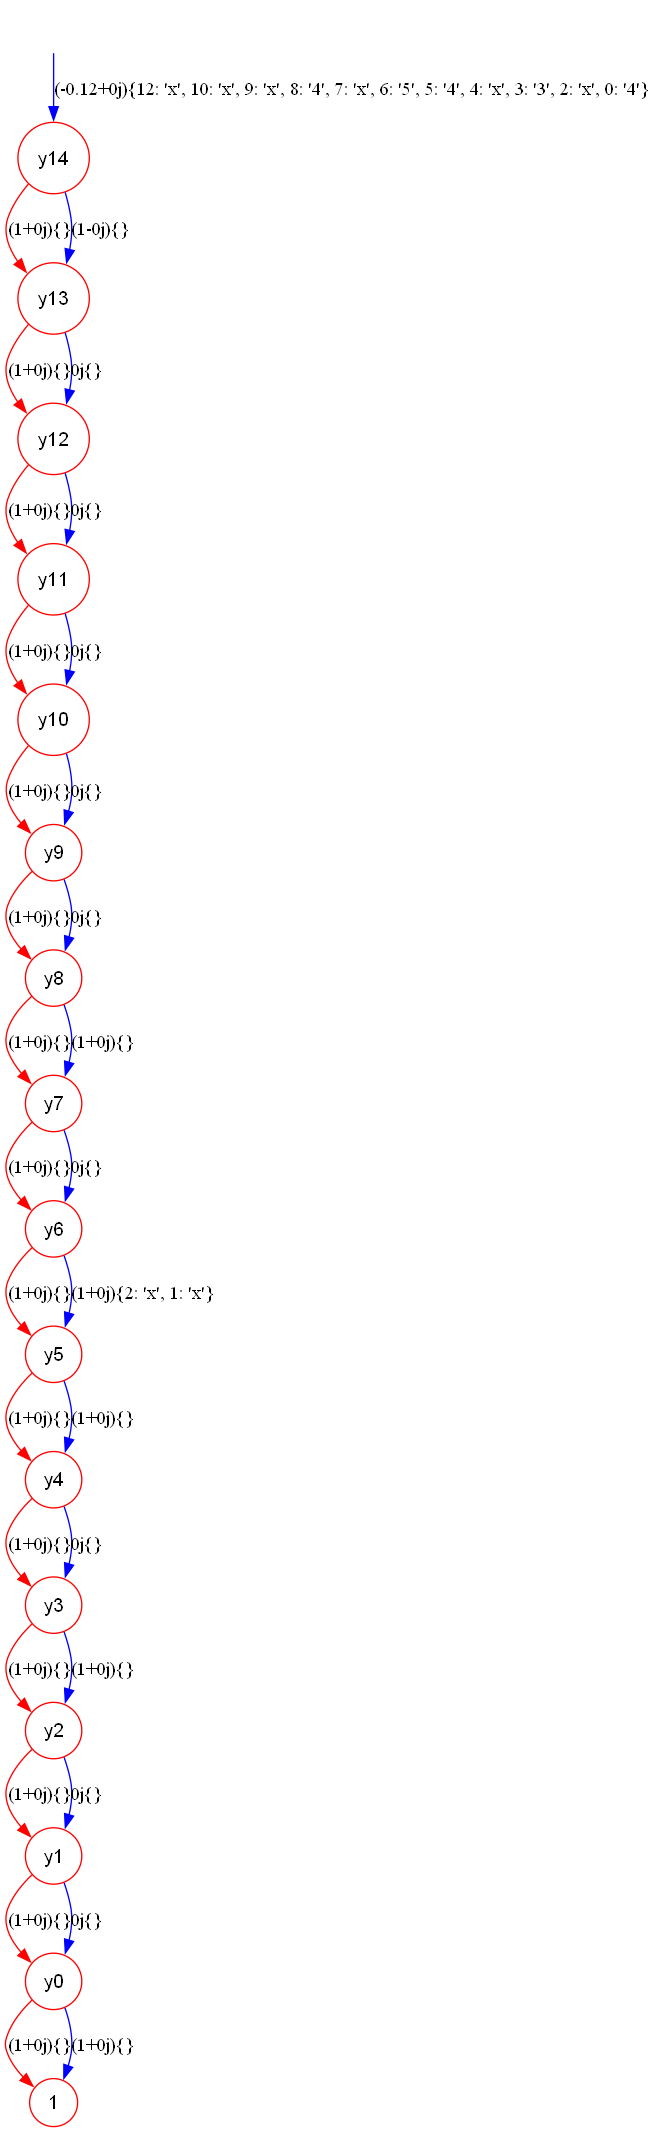

In [49]:
n=5
m=100

cir=gen_cir('Random_Clifford_T',n,m)
tdd=simulate(cir,True,n)
tdd.show()

In [50]:
# State Preparation
anc_num = 10
t_start = time.time()
cir_end = state_pre(tdd.self_copy(),anc_num)
print('Time consumption:', time.time()-t_start)
print('Gates num:', len(cir_end.data))
print(cir_end)

1
3


In [ ]:
# For verification
tdd_new = extend_tdd(tdd,anc_num)
print('1')
cir_head = QuantumCircuit(n+anc_num)
cir_end = cir_end.to_qis_cir()
tdd_new2 = update_tdd(tdd_new,cir_head,cir_end)
print('2')
tdd_new2 = renormalize(tdd_new2)
print('3')
print(is_successful(tdd_new2,n,anc_num))
tdd_new2.show()

In [ ]:
cir_end.draw('mpl')